# Search Demo of Our Method

## install and import packages

In [3]:
!pip install python-terrier

In [2]:
!pip install fastrank

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 891 kB 13.3 MB/s 


In [1]:
import pandas as pd
import pyterrier as pt
import os

In [2]:
if not pt.started():
    pt.init()

PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



In [3]:
import csv
import pandas as pd
import numpy as np
import string
import random

## read and preprocess data

In [4]:
r_df = pd.read_csv("/content/drive/MyDrive/22fall/549/549project/final/recipes.csv")

In [5]:
all_samples = r_df.shape[0]

In [6]:
all_queries = pd.read_csv('/content/drive/MyDrive/22fall/549/549project/update/all_queries.csv')

In [7]:
qrels = pd.read_csv('/content/drive/MyDrive/22fall/549/549project/update/all_qrels.csv')

In [8]:
title_list = []
for i in range(len(r_df)):
  title_list.append([str(r_df["title"][i]),str(r_df["docno"][i]),str(r_df["rating"][i]),str(r_df["ingredients"][i]),str(r_df["instructions"][i])])
re_df = pd.DataFrame(title_list, columns =["title","docno","rating","ingredients","instructions"])

## create index for all attributes

In [9]:
attributes = ["title","ingredients"]
recipe_index = dict()

In [10]:
import os
for attribute in attributes:
  index_path = os.path.join("/content", attribute)
  if not os.path.exists(index_path + "/data.properties"):
    pd_indexer = pt.DFIndexer(index_path)
    indexref = pd_indexer.index(re_df[attribute], re_df)
  else:
    indexref = pt.IndexRef.of(index_path + "/data.properties")
  recipe_index[attribute] = pt.IndexFactory.of(indexref)

## learning to rank (our method)

In [11]:
def my_custom_weighting(keyFreq, posting, entryStats, collStats):
    '''
    Computes the Pivoted Normalization score of this document for a given query
    
    :param keyFrequency(float): the weight of the term in the query, usually 1 except during PRF.
    :param posting(Posting): access to the information about the occurrence of the term in the current document (frequency, document length etc).
    :param entryStats(EntryStatistics): access to the information about the occurrence of the term in the whole index (document frequency, etc.).
    :param collStats(CollectionStatistics): access to the information about the index as a whole (number of documents, etc).
    :return: the Pivoted Normalization score of this document for the given query
    '''
    import numpy as np
    k0 = 0.2
    k1 = 2
    k2 = 0.5
    b = 0.75
    k3 = 5
    df = entryStats.getDocumentFrequency()
    dl = posting.getDocumentLength()
    tf = posting.getFrequency()
    N = collStats.getNumberOfDocuments()
    avdl = collStats.getAverageDocumentLength()
    my_score = (np.log((N + 1) / df)) * ((k1 + 1) * tf) / (k1 * (1 - b + b * dl / avdl) + tf) * ((k3 + 1) * keyFreq) / (k3 + keyFreq)
    return my_score

In [12]:
RANK_CUTOFF = 10
SEED = 42

from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(all_queries, test_size=20, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=20, random_state=SEED)

In [18]:
import fastrank
feats = dict()
ca_pipes = dict()
for attribute in attributes:
    my_weighting = pt.BatchRetrieve(recipe_index[attribute], wmodel=my_custom_weighting, num_results=5000)
    tfidf = pt.BatchRetrieve(recipe_index[attribute], wmodel="TF_IDF", num_results=5000)
    bm25 = pt.BatchRetrieve(recipe_index[attribute], wmodel="BM25", num_results=5000)

    feats[attribute] = (my_weighting) >> pt.text.get_text(recipe_index[attribute], ["title","docno","rating","ingredients","instructions"]) >> (
        pt.transformer.IdentityTransformer()
        **
        bm25
        **
        tfidf
        **
        pt.BatchRetrieve(recipe_index[attribute], wmodel="CoordinateMatch")
        **
        (pt.apply.doc_score(lambda row: int(row["rating"] is not None and float(row["rating"]) >= 4.5)))
        **
        (pt.text.scorer(body_attr="ingredients", takes='docs', wmodel='BM25'))
        **
        (pt.text.scorer(body_attr="instructions", takes='docs', wmodel='BM25'))
    )

    train_request = fastrank.TrainRequest.coordinate_ascent()

    params = train_request.params
    params.init_random = True
    params.normalize = True
    params.seed = 1234567

    ca_pipes[attribute] = feats[attribute] >> pt.ltr.apply_learned_model(train_request, form='fastrank')

    %time ca_pipes[attribute].fit(train_topics, qrels)

23:29:08.336 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
23:29:22.236 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
CPU times: user 1min 34s, sys: 930 ms, total: 1min 34s
Wall time: 1min 24s
23:31:12.562 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
23:31:32.457 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has

## functions for integrating features

In [15]:
doc_list = list(r_df["docno"])
doc_dict = {}
for i in range(len(doc_list)):
  doc_dict[doc_list[i]] = i

In [16]:
import numpy as np

def normalize(raw_scores):
  min = np.min(raw_scores)
  max = np.max(raw_scores)
  norm_scores = (raw_scores-min)/max

  return norm_scores


In [86]:
doc_ranking = list(r_df["docno"])
output_num = 10
all_samples = r_df.shape[0]
def return_results(full_query, attribute_weights, number_filter, num_recipes):

  doc_ranking_dict = dict()
  for i in range(len(doc_ranking)):
    doc_ranking_dict[doc_ranking[i]] = 0

  for attribute in full_query:

    query = pd.DataFrame([[attribute, full_query[attribute]]], columns=["qid", "query"])
    if attribute == "no-ingredients":
      # bm25 = pt.BatchRetrieve(recipe_index["ingredients"], wmodel="BM25",num_results=all_samples)
      model = ca_pipes["ingredients"]
    else:
      # bm25 = pt.BatchRetrieve(recipe_index[attribute], wmodel="BM25", num_results=all_samples)
      model = ca_pipes[attribute]

    results = model.transform(query).sort_values('score',ascending = False)
    raw_scores = list(results["score"])
    norm_scores = normalize(raw_scores)
    attribute_weight = attribute_weights[attribute]

    score = dict()
    for i in range(len(doc_ranking)):
      score[doc_ranking[i]] = 0
    for i in range(len(results["docno"])):
      score[results["docno"][i]] = norm_scores[i]  

    for idx, docno in enumerate(score):
      doc_ranking_dict[docno] += attribute_weight*score[docno]

  sorted_ranking  = list(sorted(doc_ranking_dict.items(), key=lambda item: item[1],reverse = True))
  output_docno = []

  i = 0
  while(True):
    docno = sorted_ranking[i][0]
    result = r_df.iloc[doc_dict[docno]]
    rating = result[4]
    if type(result[9]) != str:
      continue
    else:
      calories = int(result[9].split(" ")[0])

    if rating>=number_filter["rating"][0] and rating<=number_filter["rating"][1]:
      if calories>=number_filter["calories"][0] and calories<=number_filter["calories"][1]:
        output_docno.append(docno)
    i = i+1
    if len(output_docno) == output_num or i == len(sorted_ranking):
      break

  results = r_df.iloc[doc_dict[output_docno[0]]]
  results = []
  for i in range(num_recipes):
    results.append(r_df.iloc[doc_dict[output_docno[i]]].to_frame().T)

  results = pd.concat(results).drop(['url', 'docno'], axis=1)
  results = results.rename(columns={'yields': 'num_serving', 'carbohydrateContents': 'carbohydrate', 'cholesterolContents': 'cholesterol', 'fiberContents': 'fiber', 'proteinContents': 'protein', 'saturatedFatContents': 'saturated fat', 'sodiumContents': 'sodium', 'sugarContents': 'sugar', 'fatContents': 'fat', 'unsaturatedFatContents': 'unsaturated fat'})
  return results

## Demo of our search engine

01:48:12.225 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
01:48:14.014 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
01:48:17.361 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
01:48:18.322 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

,title,total_time,rating,num_serving,ingredients,instructions,calories,carbohydrate,cholesterol,fiber,protein,saturated fat,sodium,sugar,fat,unsaturated fat
7616,Blue Cheese and Asparagus Pizza,30,4.3,6 servings,"['1 bunch asparagus, trimmed and snapped into pieces', '1 teaspoon olive oil, or as needed', 'salt and black pepper to taste', '0.5 cup pizza sauce', '1 (14 ounce) prebaked pizza crust (such as Boboli®)', '0.75 cup crumbled blue cheese']","Preheat an oven to 350 degrees F (175 degrees C).\nPlace asparagus on a baking sheet; drizzle with olive oil and sprinkle with salt and pepper.\nBake the asparagus in the preheated oven for 10 minutes.\nWhile asparagus is baking, spread the pizza sauce over the pizza crust. Distribute asparagus pieces and crumbles of blue cheese evenly over the pizza.\nReturn pizza to center rack of preheated oven; bake until the cheese is melted and bubbling, 8 to 10 more minutes.",291 kcal,39 g,19 mg,3 g,15 g,5 g,733 mg,3 g,10 g,0 g
33281,Fig and Goat Cheese Pizza,78,4.6,4 servings,"['1 cup lukewarm water', '1 (.25 ounce) envelope active dry yeast', '3 cups all-purpose flour', '1 teaspoon vegetable oil', '1 teaspoon salt', '8 dried figs', '1 medium red onion, thinly sliced', '1 tablespoon olive oil', '1 pinch salt', '1 teaspoon dried thyme', '1 teaspoon fennel seeds', '4 ounces goat cheese', '1 tablespoon olive oil, or as needed']","Pour water into a large bowl and sprinkle yeast over top. Let stand for a few minutes to dissolve. Mix in oil, salt, and flour to make a dough. When dough is too stiff to stir, turn out onto a floured surface, and knead for about 5 minutes. Place into an oiled bowl, and cover with a clean towel. Set aside to rise for about 45 minutes.\nPlace figs into a small bowl, and pour boiling water over them. Let stand for about 10 minutes, then drain and chop. Set aside.\nMeanwhile, heat 1 tablespoon of olive oil in a skillet over medium heat. Add onions; cook and stir until they are wilted and soft. Reduce heat to low, and season with salt. Continue to cook and stir until onions are dark brown, 5 to 10 minutes. Stir in thyme, fennel seed, and figs, and remove from the heat.\nPreheat the oven to 450 degrees F (220 degrees C). Punch down pizza dough, and stretch into a circle about 1/4-inch thick. Place on a lightly greased pizza pan or baking sheet. Brush surface lightly with remaining olive oil. Spread onion and fig mixture over crust. It will be sparse, but there is plenty of flavor. Dot with pieces of goat cheese.\nBake for 15 to 18 minutes in the preheated oven, or until crust has turned golden brown at edges.",630 kcal,101 g,22 mg,8 g,18 g,7 g,736 mg,22 g,18 g,0 g


Blue Cheese and Asparagus Pizza


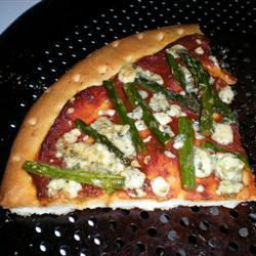

Fig and Goat Cheese Pizza


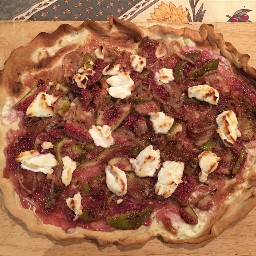

In [102]:
#@title { display-mode: "form", run: "auto" }

#@markdown What kind of food do you want?
food = 'cheese pizza' #@param {type:"string"}
#@markdown What kind of certain ingredient do you want?
include = 'oliver oil' #@param {type:"string"}
#@markdown What kind of certain ingredient do you don't want?
exclude = 'beef' #@param {type:"string"}
#@markdown How many recipes do you want?
num_recipes = 2 #@param {type:"slider", min:1, max:5, step:1}
#@markdown Do you wish to set a lowest rating to filter recipes?
low_rating = 4 #@param {type:"slider", min:0, max:5, step:0.1}
#@markdown Do you wish to set a highest rating to filter recipes?
high_rating = 5 #@param {type:"slider", min:0, max:5, step:0.1}
#@markdown Do you wish to set a lowest value for calories to filter recipes?
low_calories = 200 #@param {type:"slider", min:50, max:2000, step:50}
#@markdown Do you wish to set a highest value for calories to filter recipes?
high_calories = 1000 #@param {type:"slider", min:50, max:2000, step:50}

full_query = dict()
attribute_weights = {"title":10, "ingredients":10, "no-ingredients":3}
number_filter = dict()
full_query['title'] = food
full_query['ingredients'] = include
full_query['no-ingredients'] = exclude
number_filter['rating'] = [float(low_rating), float(high_rating)]
number_filter['calories'] = [float(low_calories), float(high_calories)]
results = return_results(full_query, attribute_weights, number_filter, num_recipes)
display(results.drop(['image'], axis=1))

from PIL import Image
import cv2
import requests
from io import BytesIO
from google.colab.patches import cv2_imshow
images_url = results['image'].tolist()
titles = results['title'].tolist()
for i, url in enumerate(images_url):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img = np.array(img)[:,:,::-1]
  h, w, _ = img.shape
  img = cv2.resize(img, (int(h*256/w), 256))
  print(titles[i])
  cv2_imshow(img)